# **2D CNN / Meryem EFE**

### **Connecting Google Drive**

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Performance Metrics Function**

In [0]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

def report_performance(predictions, labels):
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    
        
    if type(predictions).__module__ == torch.__name__ :
        predictions = predictions.tolist()
    if type(labels).__module__ == torch.__name__ :
        labels = labels.tolist()
    
    if type(predictions).__module__ == np.__name__ :
        predictions = list(predictions)
    if type(labels).__module__ == np.__name__ :
        labels = list(labels)
    

    
    size = len(genres);
    i = 0;
    
    while i < 10:
        if i in predictions:        
            for j, x in enumerate(predictions):
                if x == i:
                   predictions[j] = genres[i + size - 10]
        if i in labels:
            for j, x in enumerate(labels):
                if x == i: 
                    labels[j] = genres[i + size - 10]
        else: 
            del genres[i + size - 10]
            size -= 1
        i+=1; 
          

    data = {'y_Actual':    labels,
            'y_Predicted': predictions
            }
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
   
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()
    print(classification_report(labels, predictions))
    
    cnf = multilabel_confusion_matrix(labels, predictions)

    for i in range(0, len(genres)):
        if (cnf[i][0][1]+cnf[i][1][1]) != 0:
            print("Accuracy for", genres[i], "is:", cnf[i][1][1]/(cnf[i][0][1]+cnf[i][1][1]), "\n")

### **Data Preprocessing**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import os
import cv2

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Load the dataset and divide it into training and test sets
DATADIR = r'/content/gdrive/My Drive/machine learning/rescaled400_daha_net/'
CATEGORIES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

train_dataset = []
train_labels = []
test_dataset = []
test_labels = []

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    i = 0
    for img in os.listdir(path):
        if i < 80:
            img_array = cv2.imread(os.path.join(path, img))
            train_dataset.append(np.array(img_array))
            train_labels.append(class_num)
        else:
            img_array = cv2.imread(os.path.join(path, img))
            test_dataset.append(np.array(img_array))
            test_labels.append(class_num)
        i += 1

In [0]:
# Convert datasets to numpy arrays
train_dataset = np.array(train_dataset)
print(train_dataset.shape)
train_labels = np.array(train_labels)
print(train_labels.shape)

test_dataset = np.array(test_dataset)
print(test_dataset.shape)
test_labels = np.array(test_labels)
print(test_labels.shape)

(800, 400, 400, 3)
(800,)
(200, 400, 400, 3)
(200,)


In [0]:
# Convert datasets from numpy arrays to torchs
train_dataset = torch.from_numpy(train_dataset)
train_labels = torch.from_numpy(train_labels)

test_dataset = torch.from_numpy(test_dataset)
test_labels = torch.from_numpy(test_labels)

In [0]:
# Change the order of dimension as (N x C x H x W )
train_dataset = train_dataset.permute(0, 3, 1, 2)
print( train_dataset.size() )

test_dataset = test_dataset.permute(0, 3, 1, 2)
print( test_dataset.size() )

torch.Size([800, 3, 400, 400])
torch.Size([200, 3, 400, 400])


In [0]:
# Combine datasets and labels to create TensorDataset
train_dataset = torch.utils.data.TensorDataset(train_dataset, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_dataset, test_labels)

In [0]:
# There are 10 classes:
classes = ('blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock')

### **CNN Model**

In [0]:
# CNN Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(48*48*16, 120)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, inpt):
        x = F.relu(self.conv1(inpt))
        x = F.relu(self.conv2(x))
        x = self.pool1( x )
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2( x )
        x = self.drop2(x)
        
        
        x = F.relu(self.conv3(x))
        x = self.pool2( x )
        x = self.drop2(x)
        
        x = x.view(-1, 48*48*16)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = F.relu(self.fc2(x))
        return x

In [0]:
model = ConvNet().to(device)

In [0]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=36864, out_features=120, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [0]:
summary(model, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 398, 398]             448
            Conv2d-2         [-1, 16, 396, 396]           2,320
         MaxPool2d-3         [-1, 16, 198, 198]               0
           Dropout-4         [-1, 16, 198, 198]               0
            Conv2d-5         [-1, 16, 196, 196]           2,320
         MaxPool2d-6           [-1, 16, 98, 98]               0
           Dropout-7           [-1, 16, 98, 98]               0
            Conv2d-8           [-1, 16, 96, 96]           2,320
         MaxPool2d-9           [-1, 16, 48, 48]               0
          Dropout-10           [-1, 16, 48, 48]               0
           Linear-11                  [-1, 120]       4,423,800
          Dropout-12                  [-1, 120]               0
           Linear-13                   [-1, 10]           1,210
Total params: 4,432,418
Trainable param

In [0]:
# Parameters
num_epochs = 100
batch_size = 20
learning_rate = 0.001

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.9)

### **Training Model**

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
def get_accuracy( loader ):
    n_correct = 0
    n_samples = 0
    for images, labels in loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        labels = labels.long()
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    return acc

Epoch [1/100], Loss: 2.3228, Train Accuracy: 10.7500, Validation Accuracy: 8.0000
Epoch [2/100], Loss: 2.3036, Train Accuracy: 10.1250, Validation Accuracy: 9.5000
Epoch [3/100], Loss: 2.3063, Train Accuracy: 9.8750, Validation Accuracy: 11.0000
Epoch [4/100], Loss: 2.3104, Train Accuracy: 11.0000, Validation Accuracy: 9.5000
Epoch [5/100], Loss: 2.0942, Train Accuracy: 13.6250, Validation Accuracy: 12.0000
Epoch [6/100], Loss: 2.2870, Train Accuracy: 15.8750, Validation Accuracy: 13.0000
Epoch [7/100], Loss: 2.1997, Train Accuracy: 11.2500, Validation Accuracy: 11.0000
Epoch [8/100], Loss: 2.3339, Train Accuracy: 10.6250, Validation Accuracy: 14.0000
Epoch [9/100], Loss: 2.1532, Train Accuracy: 16.1250, Validation Accuracy: 17.0000
Epoch [10/100], Loss: 2.1636, Train Accuracy: 14.6250, Validation Accuracy: 17.0000
Epoch [11/100], Loss: 2.4700, Train Accuracy: 18.0000, Validation Accuracy: 11.5000
Epoch [12/100], Loss: 2.2270, Train Accuracy: 17.1250, Validation Accuracy: 15.5000
Epoch

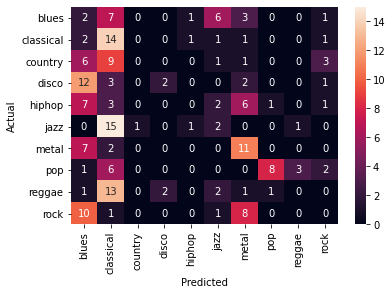

              precision    recall  f1-score   support

       blues       0.04      0.10      0.06        20
   classical       0.19      0.70      0.30        20
     country       0.00      0.00      0.00        20
       disco       0.50      0.10      0.17        20
      hiphop       0.00      0.00      0.00        20
        jazz       0.13      0.10      0.11        20
       metal       0.33      0.55      0.42        20
         pop       0.80      0.40      0.53        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.16       200
weighted avg       0.20      0.20      0.16       200

Accuracy for blues is: 0.041666666666666664 

Accuracy for classical is: 0.1917808219178082 

Accuracy for country is: 0.0 

Accuracy for disco is: 0.5 

Accuracy for hiphop is: 0.0 

Accuracy for jazz is: 0.13333333333333333 

Accuracy for 

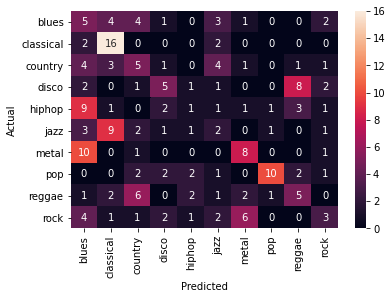

              precision    recall  f1-score   support

       blues       0.12      0.25      0.17        20
   classical       0.44      0.80      0.57        20
     country       0.23      0.25      0.24        20
       disco       0.36      0.25      0.29        20
      hiphop       0.12      0.05      0.07        20
        jazz       0.12      0.10      0.11        20
       metal       0.42      0.40      0.41        20
         pop       0.77      0.50      0.61        20
      reggae       0.26      0.25      0.26        20
        rock       0.25      0.15      0.19        20

    accuracy                           0.30       200
   macro avg       0.31      0.30      0.29       200
weighted avg       0.31      0.30      0.29       200

Accuracy for blues is: 0.125 

Accuracy for classical is: 0.4444444444444444 

Accuracy for country is: 0.22727272727272727 

Accuracy for disco is: 0.35714285714285715 

Accuracy for hiphop is: 0.125 

Accuracy for jazz is: 0.11764705882352

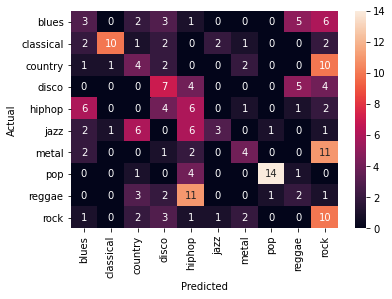

              precision    recall  f1-score   support

       blues       0.18      0.15      0.16        20
   classical       0.83      0.50      0.62        20
     country       0.21      0.20      0.21        20
       disco       0.29      0.35      0.32        20
      hiphop       0.17      0.30      0.22        20
        jazz       0.50      0.15      0.23        20
       metal       0.40      0.20      0.27        20
         pop       0.88      0.70      0.78        20
      reggae       0.14      0.10      0.12        20
        rock       0.21      0.50      0.30        20

    accuracy                           0.32       200
   macro avg       0.38      0.32      0.32       200
weighted avg       0.38      0.32      0.32       200

Accuracy for blues is: 0.17647058823529413 

Accuracy for classical is: 0.8333333333333334 

Accuracy for country is: 0.21052631578947367 

Accuracy for disco is: 0.2916666666666667 

Accuracy for hiphop is: 0.17142857142857143 

Accuracy fo

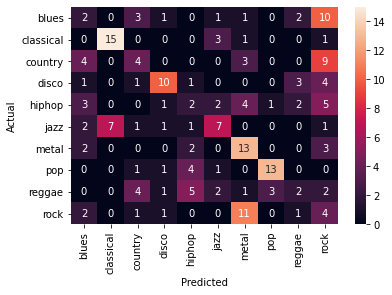

              precision    recall  f1-score   support

       blues       0.12      0.10      0.11        20
   classical       0.68      0.75      0.71        20
     country       0.27      0.20      0.23        20
       disco       0.62      0.50      0.56        20
      hiphop       0.13      0.10      0.11        20
        jazz       0.44      0.35      0.39        20
       metal       0.38      0.65      0.48        20
         pop       0.76      0.65      0.70        20
      reggae       0.20      0.10      0.13        20
        rock       0.10      0.20      0.14        20

    accuracy                           0.36       200
   macro avg       0.37      0.36      0.36       200
weighted avg       0.37      0.36      0.36       200

Accuracy for blues is: 0.125 

Accuracy for classical is: 0.6818181818181818 

Accuracy for country is: 0.26666666666666666 

Accuracy for disco is: 0.625 

Accuracy for hiphop is: 0.13333333333333333 

Accuracy for jazz is: 0.4375 

Accurac

In [0]:
# Training
n_total_steps = len(train_loader)
train_accuracies = []
valid_accuracies = []
loss_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.float)
        labels = labels.long()
        
        outputs = model(images)
        
        loss = criterion( outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    train_acc = get_accuracy(train_loader)
    train_accuracies.append( train_acc )
    valid_acc = get_accuracy(test_loader)
    valid_accuracies.append( valid_acc )
    loss_list.append( loss.item() )
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}')

    if (epoch+1) % 25 == 0:
        test_pred = []
        test_lab = []
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device, dtype=torch.float)
            test_labels = test_labels.to(device, dtype=torch.float)
            test_labels = test_labels.long()
        
            outputs = model(test_images)
        
            _, predicted = torch.max(outputs, 1)
            for i in range(batch_size):
                test_lab.append( test_labels[i] )
                test_pred.append( predicted[i] )
        report_performance( test_pred, test_lab )

print('Finished Training')

### **Testing Model and Plotting Graphs of Results**

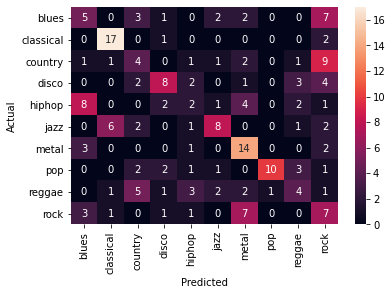

              precision    recall  f1-score   support

       blues       0.25      0.25      0.25        20
   classical       0.65      0.85      0.74        20
     country       0.22      0.20      0.21        20
       disco       0.50      0.40      0.44        20
      hiphop       0.17      0.10      0.12        20
        jazz       0.53      0.40      0.46        20
       metal       0.44      0.70      0.54        20
         pop       0.91      0.50      0.65        20
      reggae       0.29      0.20      0.24        20
        rock       0.19      0.35      0.25        20

    accuracy                           0.40       200
   macro avg       0.42      0.40      0.39       200
weighted avg       0.42      0.40      0.39       200

Accuracy for blues is: 0.25 

Accuracy for classical is: 0.6538461538461539 

Accuracy for country is: 0.2222222222222222 

Accuracy for disco is: 0.5 

Accuracy for hiphop is: 0.16666666666666666 

Accuracy for jazz is: 0.5333333333333333 


In [0]:
def test():
    test_pred = []
    test_labels = []
    correct_2 = 0
    correct_3 = 0
    for images, labels in test_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        labels = labels.long()
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        test_labels += labels
        test_pred += predicted

        _, predicted = torch.topk(outputs.data, 3)
        
         # Total correct predictions for top-2 and top-3 accuracies
        correct_2 += (predicted[:,0].to(device) == labels).sum() + (predicted[:,1].to(device) == labels).sum()  
        correct_3 += (predicted[:,0].to(device) == labels).sum() + (predicted[:,1].to(device) == labels).sum()  + (predicted[:,2].to(device) == labels).sum() 
    
    accuracy_top_2 = 100 * correct_2 / len(test_labels)
    accuracy_top_3 = 100 * correct_3 / len(test_labels)

    report_performance( test_pred, test_labels )
    print("Top 2 prediction accuracy: %.1f%%" %(accuracy_top_2.item()))
    print("Top 3 prediction accuracy: %.1f%%" %(accuracy_top_3.item()))

test()

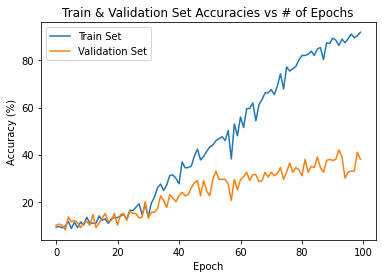

In [0]:
# Plot change in accuracies vs epochs
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.title('Train & Validation Set Accuracies vs # of Epochs')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper left')
plt.show()

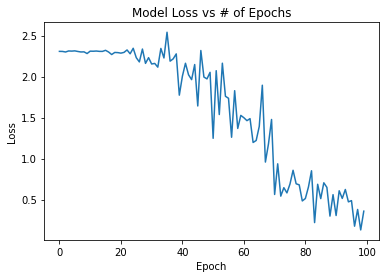

In [0]:
# Plot change in loss vs epochs
plt.plot(loss_list)
plt.title('Model Loss vs # of Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()